A Monte Carlo Pricer

Demonstrated features:
* Numba Vectorize
* NumbaPro CUDA Vectorize
* NumbaPro cuRAND


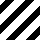
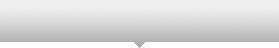
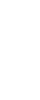
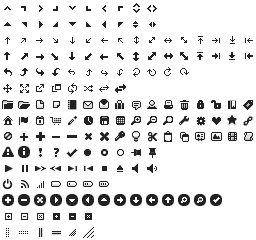
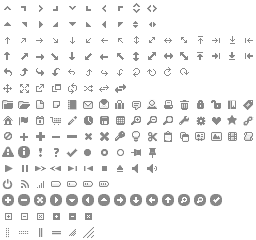
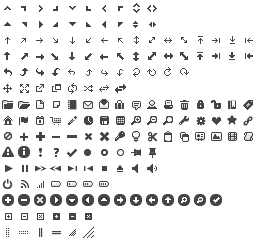
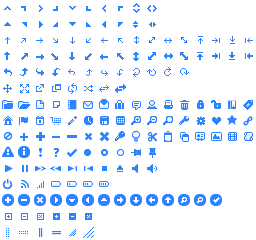
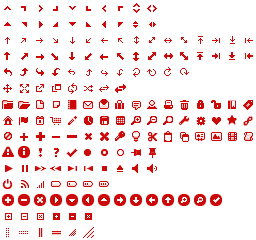
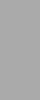
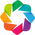
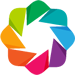
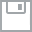
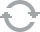
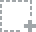
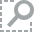
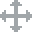
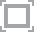
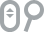

In [1]:
from __future__ import print_function, division

import sys
import datetime
import math
from math import sqrt, exp
from timeit import default_timer as timer

import numpy as np

import numba
from numba import cuda, vectorize
from numbapro.cudalib import curand

from bokeh.plotting import figure, show, output_notebook

output_notebook()

**Version information:**

In [2]:
print("This file is generated on:", datetime.datetime.now())
print("python: {0}.{1}".format(*sys.version_info[:2]))
print("numpy:", np.__version__)
print("numba:", numba.__version__)
print("CUDA GPU:", cuda.gpus[0].name)

This file is generated on: 2015-06-16 11:42:52.331908
python: 3.4
numpy: 1.9.2
numba: 0.19.1
CUDA GPU:

 b'GeForce GT 650M'


## Setup

Setup constants for the simulator

In [3]:
StockPrice = 20.83
StrikePrice = 21.50
Volatility = 0.021  # per year
InterestRate = 0.20
Maturity = 5. / 12.
NumPath = 500000
NumStep = 200

A simulation driver that uses different pricer implementation

In [4]:
def driver(pricer, pinned=False):
    paths = np.zeros((NumPath, NumStep + 1), order='F')
    paths[:, 0] = StockPrice
    DT = Maturity / NumStep

    if pinned:
        with cuda.pinned(paths):
            ts = timer()
            pricer(paths, DT, InterestRate, Volatility)
            te = timer()
    else:
        ts = timer()
        pricer(paths, DT, InterestRate, Volatility)
        te = timer()

    ST = paths[:, -1]
    PaidOff = np.maximum(paths[:, -1] - StrikePrice, 0)
    print('Result')
    fmt = '%20s: %s'
    print(fmt % ('stock price', np.mean(ST)))
    print(fmt % ('standard error', np.std(ST) / sqrt(NumPath)))
    print(fmt % ('paid off', np.mean(PaidOff)))
    optionprice = np.mean(PaidOff) * exp(-InterestRate * Maturity)
    print(fmt % ('option price', optionprice))

    print('Performance')
    NumCompute = NumPath * NumStep
    print(fmt % ('Mstep/second', '%.2f' % (NumCompute / (te - ts) / 1e6)))
    print(fmt % ('time elapsed', '%.3fs' % (te - ts)))

    # Plot
    pathct = min(NumPath, 100)
    fig = figure()

    for i in range(pathct):
        fig.line(np.arange(paths[i].size), paths[i])
    print('Plotting %d/%d paths' % (pathct, NumPath))
    show(fig)
    return (te - ts)

## A NumPy Version

In [5]:
def numpy_step(dt, prices, c0, c1, noises):
    return prices * np.exp(c0 * dt + c1 * noises)


def numpy_mcp(paths, dt, interest, volatility):
    c0 = interest - 0.5 * volatility ** 2
    c1 = volatility * np.sqrt(dt)

    for j in range(1, paths.shape[1]):
        prices = paths[:, j - 1]
        noises = np.random.normal(0., 1., prices.size)
        paths[:, j] = numpy_step(dt, prices, c0, c1, noises)

Testing

In [6]:
numpy_runtime = driver(numpy_mcp)

Result
         stock price: 22.6403733603
      standard error: 0.000433461621696
            paid off: 1.1403776549
        option price: 1.04919809196
Performance
        Mstep/second: 17.05
        time elapsed: 5.864s
Plotting 100/500000 paths

## A Numba Vectorize Version

In [7]:
function_signature = ['float64(float64, float64, float64, float64, float64)']


@vectorize(function_signature, target='cpu')
def numba_step(last, dt, c0, c1, noise):
    return last * math.exp(c0 * dt + c1 * noise)


def numba_mcp(paths, dt, interest, volatility):
    c0 = interest - 0.5 * volatility ** 2
    c1 = volatility * np.sqrt(dt)

    for j in range(1, paths.shape[1]):
        prices = paths[:, j - 1]
        noises = np.random.normal(0., 1., prices.size)
        numba_step(prices, dt, c0, c1, noises, out=paths[:, j])

Testing

In [8]:
numba_runtime = driver(numba_mcp)

Result
         stock price: 22.6400848902
      standard error: 0.000433782444472
            paid off: 1.14008847666
        option price: 1.04893203514
Performance
        Mstep/second: 18.13
        time elapsed: 5.516s
Plotting 100/500000 paths

## A NumbaPro CUDA Version

Uses cuRAND for on GPU random number generation

In [9]:
@vectorize(function_signature, target='cuda')
def numbapro_cuda_step(last, dt, c0, c1, noise):
    return last * math.exp(c0 * dt + c1 * noise)


def numbapro_cuda_mcp(paths, dt, interest, volatility):
    n = paths.shape[0]

    # Instantiate cuRAND PRNG
    prng = curand.PRNG(curand.PRNG.MRG32K3A)

    # Allocate device side array
    d_normdist = cuda.device_array(n, dtype=np.double)

    c0 = interest - 0.5 * volatility ** 2
    c1 = volatility * math.sqrt(dt)

    # Simulation loop
    d_last = cuda.to_device(paths[:, 0])
    for j in range(1, paths.shape[1]):
        prng.normal(d_normdist, mean=0, sigma=1)
        d_paths = cuda.to_device(paths[:, j])
        numbapro_cuda_step(d_last, dt, c0, c1, d_normdist, out=d_paths)
        d_paths.copy_to_host(paths[:, j])
        d_last = d_paths

Testing

In [10]:
cuda_runtime = driver(numbapro_cuda_mcp)

Result
         stock price: 22.6396622693
      standard error: 0.00043454558027
            paid off: 1.13966588801
        option price: 1.04854323481
Performance
        Mstep/second: 50.91
        time elapsed: 1.964s
Plotting 100/500000 paths

Speedups

In [11]:
print("Numba CPU speedup over NumPy:", numpy_runtime / numba_runtime)
print("NumbaPro CUDA speedup over Numba CPU:", numba_runtime / cuda_runtime)

Numba CPU speedup over NumPy: 1.0629691578768157
NumbaPro CUDA speedup over Numba CPU: 2.8084824692600203
